## Predictive Machine Maintenance & Classification

#### Overview

The "Machine Predictive Maintenance & Classification" project focuses on developing a predictive model to classify the operational status(Failure or Not) and the type of failure of industrial machines. Utilizing the data set mentioned below, this project aims to harness the power of machine learning to anticipate machine failures, thus enabling proactive maintenance and minimizing unexpected downtimes

#### Goals

1. Classify Machine Status : Predict whether a machine likely to function normally or is it likely to fail in the near future
2. Identify Failure Types : Determine the specific type of failure that the machine might encounter

#### Learning Algorithm

Since the goal is to predict two outcomes, i.e. Target (failure or not) and Failure Type, we will implement a **Multi-Output Classifier** to predict the two key aspects. We will base the predictive model on **Random Forest** algorithm, for its ability to handle complex datasets with multiple features and classes effectively. 

#### Expected Objective

By employing advanced machine learning techniques like multi-output classification with Random Forest, the project aims to achieve high accuracy in predicting machine failures. This capability allows for proactive maintenance scheduling, minimizing unplanned downtime and associated costs

In [552]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

In [553]:
# Function To Load Data

def load_data(filename):
    print("Data Info\n")
    df=pd.read_csv(filename)
    print(df.info())
    return df


In [554]:
# Function to check & preprocess data

def check_preprocess(filename,dataframe):
    
    df = check_data(dataframe)
    dfp=preprocess(df)
    
    return dfp

In [555]:
# Function to check for missing data. If missing data is found, drop rows with missing column values

def check_data(df):
    print("\n")
    print("Checking for missing data...")
    missing_data = df.isnull().sum()
    if missing_data.any():
        print("Missing data found:\n", missing_data[missing_data > 0])
        return df.dropna()
    else:
        print("No missing data \n")
        return df
    

In [556]:
#Function to drop 'Product ID' and 'UID'

def preprocess(df):
    if 'Product ID' in df.columns:
        print("Droping ProductID...")
        df = df.drop(['Product ID'], axis=1)
    
    if 'UDI' in df.columns:
        print("Droping UDI...\n")
        df = df.drop(['UDI'], axis=1)
    
    #Rename columns to be shorter
    df = df.rename(mapper={'Air temperature [K]': 'Air Temperature',
                       'Process temperature [K]': 'Process Temperature',
                       'Rotational speed [rpm]': 'Rotational Speed',
                       'Torque [Nm]': 'Torque', 
                       'Tool wear [min]': 'Tool Wear'}, axis=1)
    
    print("Data info after initial cleaning\n")
    print(df.info())
    return df

In [572]:
# Function for EDA

def eda(df):
    # Visualize 'Type' data distribution
    plt.subplot(2,1,1) 
    ax=df['Type'].value_counts().plot.pie(explode=[0.1, 0.1,0.1],autopct='%1.2f%%',shadow=True,
                                         colors=["#A0937D", "#3282B8", "#75A47F"],
                                         wedgeprops={'linewidth': 3.0, 'edgecolor': 'black'});
    ax.set_title(label = "\nData Distribution for 'Type'", fontsize = 20,color='#45474B',font='Times New Roman');
        
    
    
    # Visualize 'Failure Type' data distribution
    plt.subplot(2,1,2)    
    ax= df['Failure Type'].value_counts().plot(kind='barh',figsize=(10,8), color="#254336")
    ax.set_title(label = "\nData Distribution for 'Failure Type'"
                 , fontsize = 20,color='#45474B',font='Times New Roman');
    ax.bar_label(ax.containers[0]) 
    
    
    
    #Failures Based on Product Type
    print("\nFailures For Each Product Type (0 : No Failure, 1: Failure)")
    for i in ['L', 'M', 'H']:
        df_product_type = df[df['Type'] == i]
        print("\nFor Product Type ",i)
        print(df_product_type['Target'].value_counts())
        
    
    
    #Analysis on numerical columns in the dataset
    plt.figure(figsize=(10, 8))
    numerical_columns = df.select_dtypes(include=["float", "int"]).columns

    for i, col in enumerate(numerical_columns, 1):
        plt.subplot(2, 3, i)
        p = sns.histplot(df[col], kde=True, color='#A0937D', edgecolor='black' )
        p.lines[0].set_color('crimson')
        plt.title(f'Distribution of {col}')

    plt.tight_layout()
    plt.show()


    #Correlation Matrix
    plt.figure(figsize=(6,6))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
    plt.title('\nCorrelation Matrix', fontsize = 20,color='#45474B',font='Times New Roman')
    plt.show()

In [558]:
# Function to perform encoding on categorical columns and to seperate out features and targets from the dataset

def encoding(df):
    
    # Convert categorical columns using one-hot encoding
    categorical_columns = ['Type','Failure Type']
    print("Categorical columns in dataset :",categorical_columns)
    print("Converting categorical columns using one-hot encoding...\n")
    df = pd.get_dummies(df, columns=categorical_columns)
    
    print("Replacing NA values with median\n")
    df= df.fillna(df.median())
    
    #Seperate features and target variables
    print("Seperating features and target variables\n")
    X = df.drop(['Target']+[col for col in df.columns if col.startswith('Failure Type_')], axis=1)
    y = df[['Target']+[col for col in df.columns if col.startswith('Failure Type_')]]
    
    print("Data info after cleaning and one-hot encoding\n")
    print(df.info())
    return X, y, df

In [559]:
# Function to split data to testing & training sets

def split_data(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [560]:
# Function to train multi-output random forest

def train_multi_output_rf(X_train,y_train):
    base_rf = RandomForestClassifier(random_state=42)
    multi_target_rf = MultiOutputClassifier(base_rf,n_jobs=-1)
    multi_target_rf.fit(X_train,y_train)
    return multi_target_rf


In [561]:
# Function for feature importance

def feature_importance (model, X_train):
    importances = model.estimators_[0].feature_importances_
    feature_names = X_train.columns
    feature_importance_df = pd.DataFrame({'Feature':feature_names,
                                         'Importance':importances})
    feature_importance_df=feature_importance_df.sort_values(by = 'Importance',
                                                           ascending=False)
    
    plt.figure(figsize=(12,6))
    sns.barplot(x='Importance', y='Feature', data = feature_importance_df)
    plt.title('Feature Importance')
    plt.show()

In [562]:
# Function to evaluate model

def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    accuracy = [accuracy_score(y_test.iloc[:,i], predictions[:,i]) for i in range(y_test.shape[1])]
    report = [classification_report(y_test.iloc[:,i], predictions[:,i]) for i in range(y_test.shape[1])]
    
    #Plot Confusion Matrix
    for i in range(y_test.shape[1]):
        plt.figure(figsize=(4,4))
        cm=confusion_matrix(y_test.iloc[:,i],predictions[:,i])
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f'Confusion Matrix for {y_test.columns[i]}')
        plt.tight_layout()
        plt.show()

    return accuracy,report, predictions

### The Data

Data Source : [(https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification)]

The dataset used in this project is in csv format and was gathered from Kaggle

#### Data Description

The dataset comprises various features that capture the operational state of industrial machines. The dataset contains 10000 rows, each representing a unique instance of machine operation data. The data set consists of a total of 10 columns, of which 'Type' and 'Failure Type' are categorical. The entire dataset amounts to 140 kB. The data source provides the below description for each feature in the dataset :

* UID: unique identifier ranging from 1 to 10000

* ProductID: consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number

* Air temperature: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K

* Process Temperature: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.

* Rotational Speed: calculated from powepower of 2860 W, overlaid with a normally distributed noise

* Torque: torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.

* Tool Wear: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process, and a
'machine failure' label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true.

* Target : Failure or Not

* Failure Type : Type of Failure

In [563]:

warnings.filterwarnings('ignore')
filename = "predictive_maintenance.csv"
df=load_data(filename)

Data Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB
None


### Data Cleansing 

The below 5 data clensing steps were performed on the dataset

#### 1. Check for missing data 
The dataset was checked for missing data. The check_data() checks for missing data and if an occurance of missing data is found, the row is removed from the dataset. There was no missing data found in the dataset.

#### 2. Remove unused columns
UID seems to be an index number and Product ID is an identification feature, both of which will not be used for model design and evaluation. Hence we can drop these two columns

#### 3. Rename columns
The columns can be renamed to make them a bit shorter. We can rename them by removing the units of measurement from the column names

In [564]:
df = check_preprocess(filename,df)



Checking for missing data...
No missing data 

Droping ProductID...
Droping UDI...

Data info after initial cleaning

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Type                 10000 non-null  object 
 1   Air Temperature      10000 non-null  float64
 2   Process Temperature  10000 non-null  float64
 3   Rotational Speed     10000 non-null  int64  
 4   Torque               10000 non-null  float64
 5   Tool Wear            10000 non-null  int64  
 6   Target               10000 non-null  int64  
 7   Failure Type         10000 non-null  object 
dtypes: float64(3), int64(3), object(2)
memory usage: 625.1+ KB
None


#### 4. Checking for imbalances in data
The dataset was checked for imbalances between classes by visualizing counts for each failure type. It was observed that the data is heavily imbalanced with majority of cases being a 'non-failure'

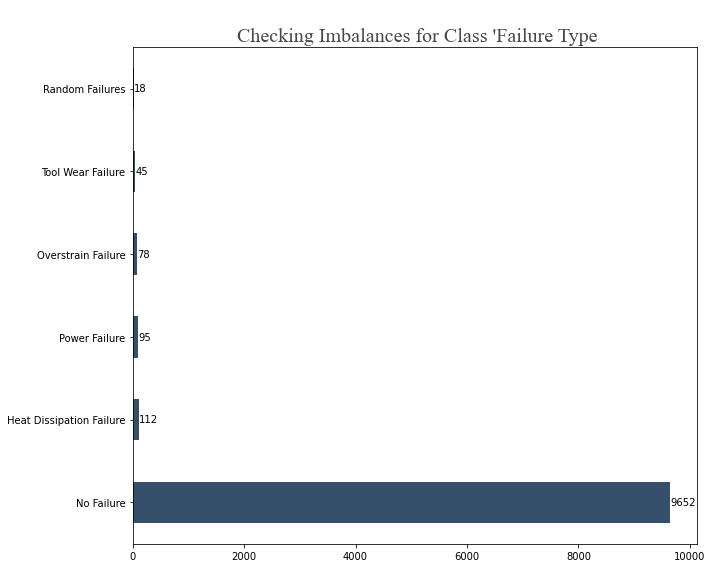

In [565]:
# Check for imbalance
ax= df['Failure Type'].value_counts().plot(kind='barh',figsize=(10,8), color="#364F6B")
ax.set_title(label = "\n Checking Imbalances for Class 'Failure Type"
                 , fontsize = 20,color='#45474B',font='Times New Roman');
ax.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

#### 5. Check for inconsistencies in data
If the data were consistenet, there would be zero cases where 'Target' is 1 (indicating true for failure) and 'Failure Type' 'No Failure' is greater than 0. From the below, it was observed that there were 9 occurances of 'Target' indicating a failure and 'Failure Type' indicating failure. Since these will cause inconsistencies, we can remove these 9 rows

In [566]:
df_failure = df[df['Target'] == 1]
df_failure['Failure Type'].value_counts()
df_failure[df_failure['Failure Type'] == 'No Failure']

,Type,Air Temperature,Process Temperature,Rotational Speed,Torque,Tool Wear,Target,Failure Type
1437,H,298.8,309.9,1439,45.2,40,1,No Fai...
2749,M,299.7,309.2,1685,28.9,179,1,No Fai...
4044,M,301.9,310.9,1419,47.7,20,1,No Fai...
4684,M,303.6,311.8,1421,44.8,101,1,No Fai...
5536,M,302.3,311.8,1363,54.0,119,1,No Fai...
5941,L,300.6,310.7,1438,48.5,78,1,No Fai...
6478,L,300.5,309.8,1663,29.1,145,1,No Fai...
8506,L,298.4,309.6,1710,27.3,163,1,No Fai...
9015,L,297.2,308.1,1431,49.7,210,1,No Fai...


In [567]:
df.drop(df_failure[df_failure['Failure Type'] == 'No Failure'].index, axis=0, inplace=True)

Similar test was conducted for Target = 0, indicating false for failure. There were 18 inconsistencies, meaning target indicated non failure while 'failure type' was noted as random failure. We can remove these inconsistent data

In [568]:
df_failure = df[df['Target'] == 0]
print(df_failure['Failure Type'].value_counts())
df_failure[df_failure['Failure Type'] == 'Random Failures']

No Failure         9643
Random Failures      18
Name: Failure Type, dtype: int64


,Type,Air Temperature,Process Temperature,Rotational Speed,Torque,Tool Wear,Target,Failure Type
1221,M,297.0,308.3,1399,46.4,132,0,Random...
1302,L,298.6,309.8,1505,45.7,144,0,Random...
1748,H,298.4,307.7,1626,31.1,166,0,Random...
2072,L,299.6,309.5,1570,35.5,189,0,Random...
2559,L,299.3,309.0,1447,50.4,140,0,Random...
3065,M,300.1,309.2,1687,27.7,95,0,Random...
3452,H,301.6,310.5,1602,32.3,2,0,Random...
5471,L,302.7,312.3,1346,61.2,170,0,Random...
5489,L,302.6,312.1,1499,35.0,215,0,Random...
5495,H,302.9,312.5,1357,55.0,12,0,Random...


In [569]:
df.drop(df_failure[df_failure['Failure Type'] == 'Random Failures'].index, axis=0, inplace=True)

### Conclusions after cleansing

From the cleansed data, we can observe that the data is still imbalanced. Another importent observation is that all 18 occurances of 'Failure Type' 'Random Failure' was removed during cleansing the data for inconsistencies. 'No Fail' volume also went down by 9. All other 'Failure Type' counts remain the same.

In [570]:
print("Data info after cleaning\n")
print(df.info(),"\n")
print(df['Failure Type'].value_counts())

Data info after cleaning

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9973 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Type                 9973 non-null   object 
 1   Air Temperature      9973 non-null   float64
 2   Process Temperature  9973 non-null   float64
 3   Rotational Speed     9973 non-null   int64  
 4   Torque               9973 non-null   float64
 5   Tool Wear            9973 non-null   int64  
 6   Target               9973 non-null   int64  
 7   Failure Type         9973 non-null   object 
dtypes: float64(3), int64(3), object(2)
memory usage: 701.2+ KB
None 

No Failure                  9643
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Name: Failure Type, dtype: int64


### Exploratory Data Analysis & Conclusions

During EDA, the below plots and conclusions were made :

#### 1. Failure Counts for Each  Product Type
The highest failure rates were observed for low quality products. To go deeper into this analysis, let us see the data distribution of product types in the dataset. Are there equal number of low, medium & high quality products?

#### 2. Data Distribution of Product Type
It was observed that 60% of the machines belong to type 'L' or 'low' product quality, 30% to 'M' or 'medium' quality and 10% to 'H' or 'high' quality

#### 3. Data Distribution of Failure Types
It can be observed that most datapoints indicated 'no failure'. The most common type of machine failure was found to be 'Heat Dissipation Failure' and 'Tool Wear Failure' was observed to be the least common failure type.

#### 4. Numerical Features and the Frequency of Occurence
Plots were generated to analyse all the numerical features and the frequency of occurence for each value. The plots also show the range of values for each feature. These plots can also be used to check for possible outliers. For e.g., in the 'Distribution of Rotational Speed' plot, it can be observed that most values lie in the range of 1250 to 2250. Any values below or above have very few occurrences and has the possibility of being outliers.

#### 5. Correlation Matrix
Correlation matrix was plotted to check for correlation between features in the dataset. It was observed that 'Air Temperature' and 'Process Temperature' are positively correlated while 'Rotational Speed' and 'Torque' are negatively correlated.


Failures For Each Product Type (0 : No Failure, 1: Failure)

For Product Type  L
0    5753
1     231
Name: Target, dtype: int64

For Product Type  M
0    2912
1      79
Name: Target, dtype: int64

For Product Type  H
0    978
1     20
Name: Target, dtype: int64


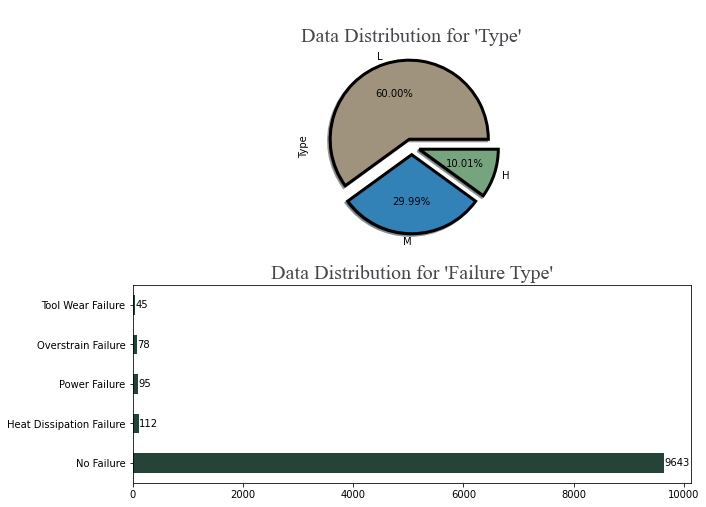

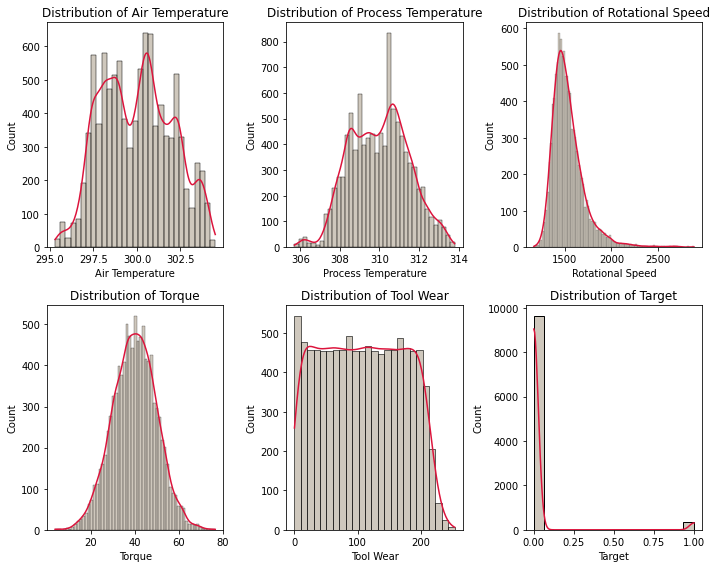

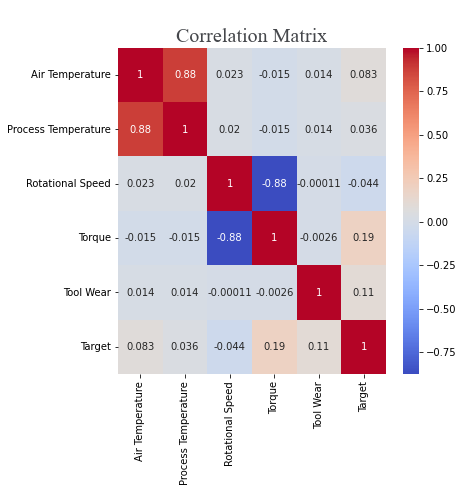

In [573]:
eda(df)

### Data Encoding & Processing

Before we can move on to designing the model, the categorical features has to be encoded. The categorical features are 'Type' and 'Failure Type'. We will use one-hot encoding for this task.

Once the encoding is complete, we replace NA values that may have been generate during the process with median values. 

Finally, we seperate out the target and features from the dataset.

From the info, we see that additional columns Type_H, Type_L, Type_M, Failure Type_Heat Dissipation Failure, Failure Type_No Failure,  Failure Type_Overstrain Failure, Failure Type_Power Failure, Failure Type_Tool Wear Failure were created as a result of encoding


(Check encoding() for implementation)

In [574]:

X, y, df = encoding(df)

Categorical columns in dataset : ['Type', 'Failure Type']
Converting categorical columns using one-hot encoding...

Replacing NA values with median

Seperating features and target variables

Data info after cleaning and one-hot encoding

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9973 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Air Temperature                        9973 non-null   float64
 1   Process Temperature                    9973 non-null   float64
 2   Rotational Speed                       9973 non-null   int64  
 3   Torque                                 9973 non-null   float64
 4   Tool Wear                              9973 non-null   int64  
 5   Target                                 9973 non-null   int64  
 6   Type_H                                 9973 non-null   uint8  
 7   Type_L                                

### Split Data Into Training & Test Set

After proper encoding and seperating data into target and features, we split the data into training & test sets. The default test size is set to 20%.

In [575]:
#Split Data
X_train, X_test, y_train, y_test = split_data(X, y)


### Model Selection, Design & Training

From EDA, we observed that the dataset contains almost 10K rows and that some of the features are correlated. This project also calls for multiple classification outputs. Keeping this in mind, we can choose **Multi Output Classifier** as our model algorithm with **Random Forests** as the base model. 


Random forests can be extended to handle multiple output variables simultaneously. This is called **multi-output random forest**. Each decision tree in the forest is trained to predict multiple target variables at the same time.


One of the major advantage of this model is that it captures correlations between the target variables, which is necessary in this case since 'Target' (Failure or No Failure) is strongly correlated to 'Failure Type' 

In [576]:
#Train Model
model = train_multi_output_rf(X_train, y_train)
    

### Feature Importance

The feature importance plot below visualizes the importance of features using a bar plot. From the plot, it can be observed that 'Torque', 'Rotational Speed' and 'Tool Wear' are the most relevent features and contribute significantly to the prediction accuracy.

But it has to be noted that from the correlation matrix, we observed that 'Torque' and 'Rotational Speed' are correlated and 'Air Temperature' and 'Process Temperature' are also correlated. So eliminating features based on feature importance alone may result in the loss of important features. 

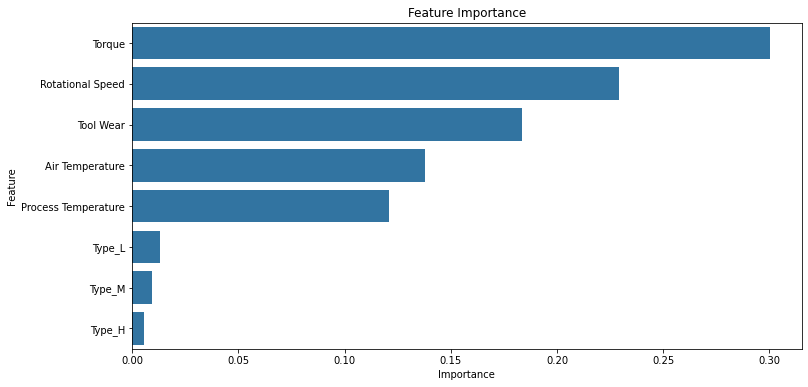

In [577]:
#Visualize feature importance
feature_importance(model, X_train) 

### Model Evaluation, Results & Analysis

#### 1.  Evaluation Using Confusion Matrix
The evaluate_model() includes confusion matrix visualization. The process iterates through each output target, computes the confusion matrix and visualizes using a heatmap. 

Confusion matrix helps visualize the performance of the classifier by showing the counts of true positives, false positives, true negatives & false negatives.

By analysing the confusion matrix, you can gain deeper insights into how well your model is performing for each output target, beyond just accuracy.

   **Results & Analysis**
From the 'Target' confusion matrix, it can be observed that the model accurately predicted most of the non failures (1932)and accurately predicted more than half of the machine failures(34). But the model did not accurately predict 25 of the machine failures and incorrectly flagged 4 points as failures when it did not actually fail. 

From the confusion matrix we can conclude that the model did an okay job predicting if the machine failed or not and also accurately predicted most cases of 'Overstrain Failure'. But, the model did not perform well in predicting 'Tool Wear' failures as well as 'Heat Dissipation' failures. 

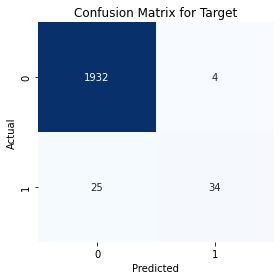

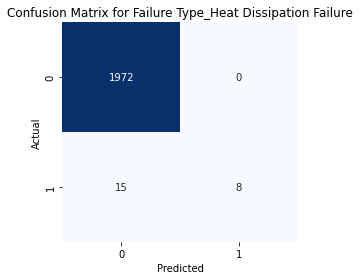

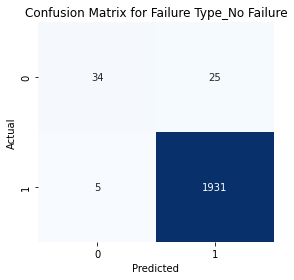

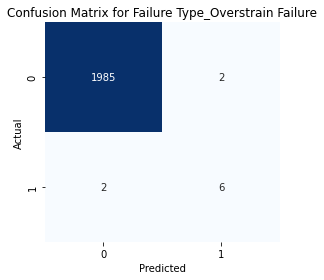

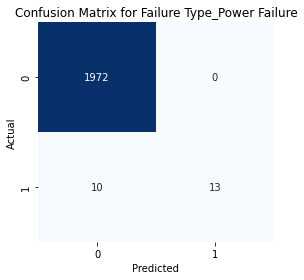

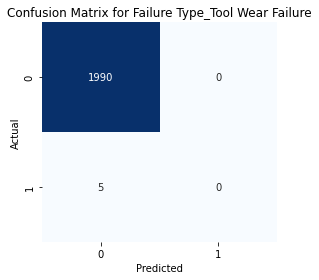

In [578]:
#Evaluate Model
accuracy, report, predictions = evaluate_model(model, X_test, y_test)


#### 2. Evaluation Using Accuracy Scores

When dealing with imbalanced data, accuracy score is generally not a good measure of model performance. This is because accuracy can be misleading when class distribution is skewed. For e.g. if 95% of the instances belong to one class, a model that always predicts this majority class will have 95% accuracy, but it would be poor at predicting the minority classes.

   **Results & Analysis**
It can be noted that the accuracy scores are very high for all the target columns. Even for 'Failure Type_Tool Wear Failure' and 'Failure Type_Heat Dissipation Failure' which we found from the above confusion matrix to have poor performance. This proves the point that accuracy score is generally not a good measure of model performance when dealing with imbalanced data. 

In [579]:

print("Accuracy Scores :\n")
for i, acc in enumerate(accuracy):
    target_name = y.columns[i]
    print(f"{target_name} Accuracy:{acc:.2f}")
        


Accuracy Scores :

Target Accuracy:0.99
Failure Type_Heat Dissipation Failure Accuracy:0.99
Failure Type_No Failure Accuracy:0.98
Failure Type_Overstrain Failure Accuracy:1.00
Failure Type_Power Failure Accuracy:0.99
Failure Type_Tool Wear Failure Accuracy:1.00


#### 3. Evaluation Using Precision, Recall & F1 Score

For imbalanced datasets, it's crucial to use evaluation metrics that consider the performance on the minority class. We can check precision, recall & F1 score for a balanced view of the model's performance.

   **Results & Analysis** The below generated classification report shows precision, recall & F1 score for all predicted targets. It can be observed that the model did a decent job at positive prediction for machine failure or no failure with an average precision of 0.94, average recall of 0.79 and average F1 score of 0.85. It can also be noted that the model did not do a good job on predicting 'Tool Wear' failures with average precision, recall & F1 score of 0.5 each. It should also be noted that the model accurately predicted true negatives and never predicted any true positives.

In [580]:
print("Classification Reports :\n")
for i, rep in enumerate(report):
    target_name = y.columns[i]
    print(f"{target_name} Classification Reports:\n{rep}")


Classification Reports :

Target Classification Reports:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1936
           1       0.89      0.58      0.70        59

    accuracy                           0.99      1995
   macro avg       0.94      0.79      0.85      1995
weighted avg       0.98      0.99      0.98      1995

Failure Type_Heat Dissipation Failure Classification Reports:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1972
           1       1.00      0.35      0.52        23

    accuracy                           0.99      1995
   macro avg       1.00      0.67      0.76      1995
weighted avg       0.99      0.99      0.99      1995

Failure Type_No Failure Classification Reports:
              precision    recall  f1-score   support

           0       0.87      0.58      0.69        59
           1       0.99      1.00      0.99      1936

    accuracy   

### Conclusion

In this project, we implemented a multi-output classification modek using Random Forest algorithm to predict machine predictive maintenance outcomes.

#### Takeaways & Drawbacks
Recognizing the imbalance in the dataset, the project demonstrated and emphasized the importance of using appropriate evaluation metrics like precision, recall & F1 score over accuracy score.

The multi-output classifier showed promising results with balanced precision and recall for majority classes. However, the model exhibited reduced performance in predicting some of the minority classes, indicating a need for further improvement in handling data imbalance.

#### Possible Improvements
Future efforts could focus on hyperparameter tuning and explore other advanced algorithms like Gradient Boosting for potentially better performance

Techniques like SMOTE or ensemble methods could be employed to further address data imbalance and improve minority class prediction.